# SPARF: Example for loading multi-view posed images of SPARF

In [1]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
import argparse
import glob
import importlib
import imp
import json
import ipyplot

project_dir = os.path.join(os.getcwd(),"..")
sys.path.append(project_dir)
%load_ext autoreload
%autoreload 2
%matplotlib inline

## util functions to plot cameras 

In [7]:
def get_camera_wireframe(scale: float = 0.3):
    """
    Returns a wireframe of a 3D line-plot of a camera symbol.
    """
    a = 0.5 * torch.tensor([-2, 1.5, 4])
    b = 0.5 * torch.tensor([2, 1.5, 4])
    c = 0.5 * torch.tensor([-2, -1.5, 4])
    d = 0.5 * torch.tensor([2, -1.5, 4])
    C = torch.zeros(3)
    F = torch.tensor([0, 0, 3])
    camera_points = [a, b, d, c, a, C, b, d, C, c, C, F]
    lines = torch.stack([x.float() for x in camera_points]) * scale
    return lines


def plot_cameras(ax, cameras, color: str = "blue", scale: float = 0.3):
    """
    Plots a set of `cameras` objects into the maplotlib axis `ax` with
    color `color`.
    """
    cam_wires_canonical = get_camera_wireframe(scale).cuda()[None]
    cam_trans = cameras[:,0:3,0:3].to(torch.float).cpu() # torch.cat(cameras[None,...],dim=0) # .get_world_to_view_transform().inverse()
    cam_disp = cameras[:,0:3,3].to(torch.float).cpu()
    cam_wires_trans = torch.bmm(cam_trans,cam_wires_canonical.repeat(len(cameras),1,1).cpu().transpose(1,2)) + cam_disp[...,None] # cam_trans.transform_points(cam_wires_canonical)
    plot_handles = []
    for wire in cam_wires_trans:
        # the Z and Y axes are flipped intentionally here!
        x_, z_, y_ = wire.detach().cpu().numpy().astype(float)
        (h,) = ax.plot(x_, y_, z_, color=color, linewidth=0.3)
        plot_handles.append(h)
    return plot_handles


def plot_camera_scene(cameras, status: str,scale=0.3):
    """
    Plots a set of predicted cameras `cameras` and their corresponding
    ground truth locations `cameras_gt`. The plot is named with
    a string passed inside the `status` argument.
    """
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    ax.clear()
    ax.set_title(status)
    handle_cam = plot_cameras(ax, cameras, color="#812CE5",scale=scale)
#     handle_cam_gt = plot_cameras(ax, cameras_gt, color="#FF7D1E",scale=scale)
    plot_radius = 4
    ax.set_xlim3d([-plot_radius, plot_radius])
    ax.set_ylim3d([-plot_radius, plot_radius])
    ax.set_zlim3d([-plot_radius, plot_radius])
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_zlabel("y")
    labels_handles = {
        "cameras": handle_cam[0],
#         "GT cameras": handle_cam_gt[0],
    }
    ax.legend(
        labels_handles.values(),
        labels_handles.keys(),
        loc="upper center",
        bbox_to_anchor=(0.5, 0),
    )
    plt.show()
    return fig


def save_cameras(cameras, save_path, scale=0.22, dpi=200):
    import mpl_toolkits
    fig = plt.figure()
    ax = mpl_toolkits.mplot3d.axes3d.Axes3D(fig)
    ax.set_xlim(-3.0, 3.0)
    ax.set_ylim(-3.0, 3.0)
    ax.set_zlim(-1.8, 1.8)
    ax.scatter(xs=[0], ys=[0], zs=[0], linewidth=3, c="r")
    plot_cameras(ax, cameras, color="blue", scale=scale)
    plt.savefig(save_path, dpi=dpi)
    plt.close(fig)

## load the dataset

In [8]:
from SPARFDataset import SPARFDataset
views_split = "test" # split of views ["train","test","hard"]
object_class = "car" # categories 
n_views = None # all views available in that view_split for shape of index = index
dset_partition = -1 # -1 to include all 20 partitions of the data of that class [0:19]m otherwise takes just a portiona of the data 
data_dir = os.path.join(project_dir,"data","SPARF_images")
return_as_lists=False # defulat False , returns dictionary of tensors instead of dictionary of lists with each list size is `n_views`


dset = SPARFDataset(data_dir, views_split=views_split, z_near=0.01, z_far=1000.0, n_views=n_views, object_class=object_class, dset_partition=dset_partition,return_as_lists=return_as_lists)

Loading NeRF synthetic dataset /home/hamdiaj/notebooks/learning_torch/data/sparf_pytorch/examples/../data/SPARF_images/car
52 instances in split test


## visualize an example 

shape path:/home/hamdiaj/notebooks/learning_torch/data/sparf_pytorch/examples/../data/SPARF_images/car/58d9741ad324623e9872e22d6b8eb647 
img_id:10 
focal length:482.842712474619



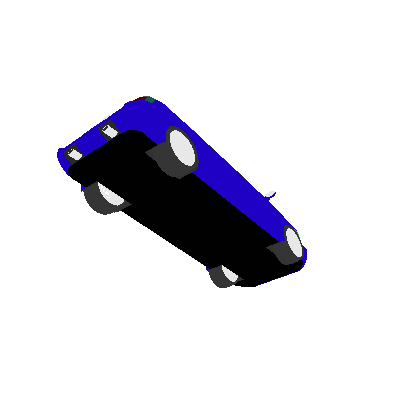
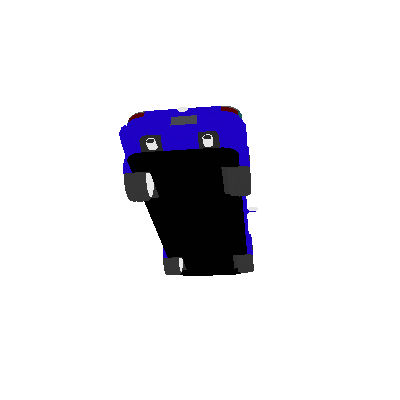
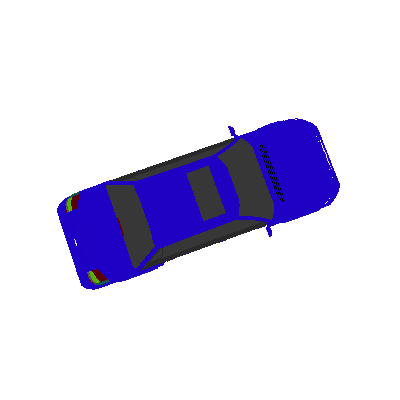
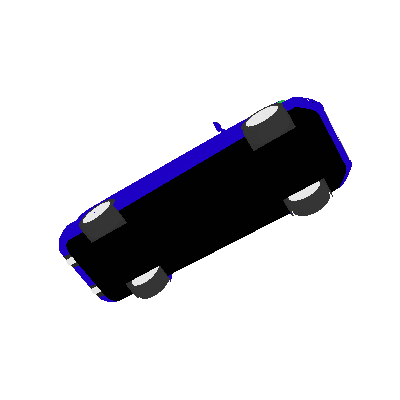
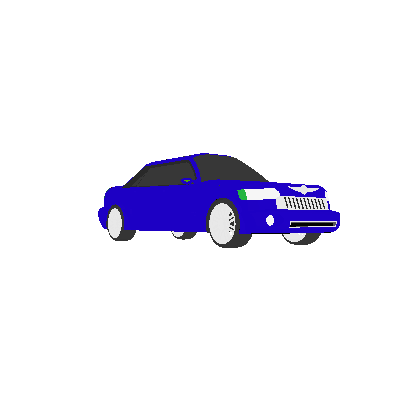
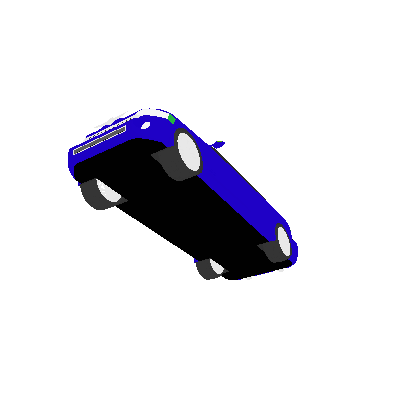
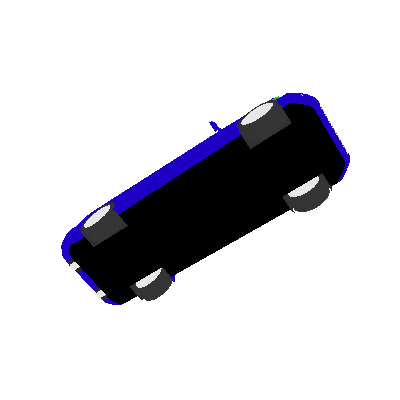
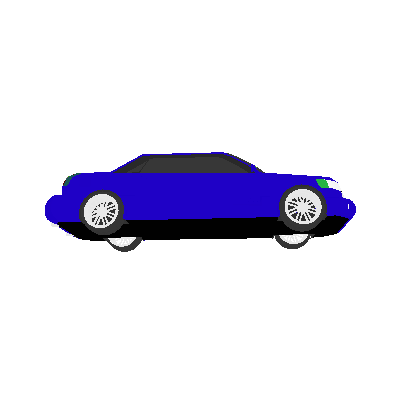
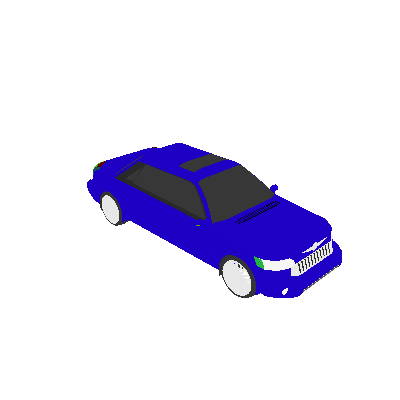
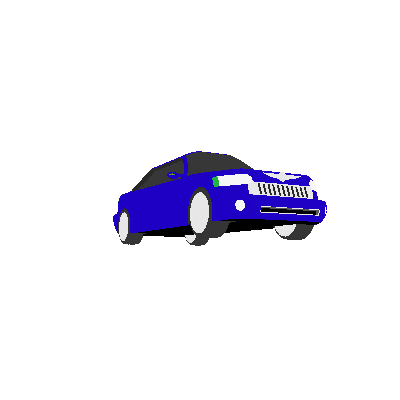
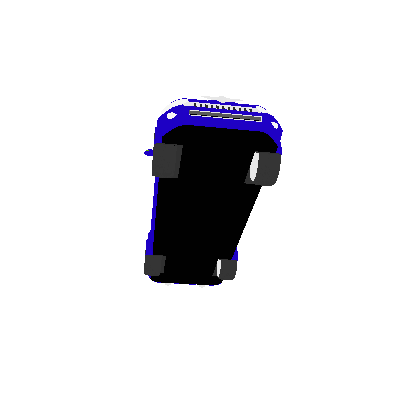
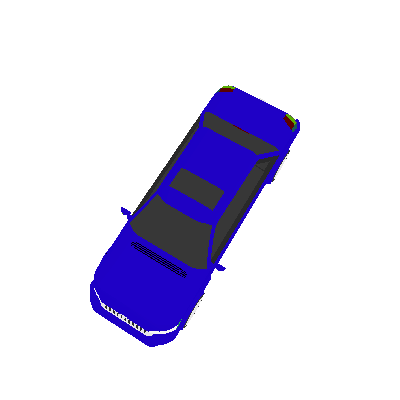
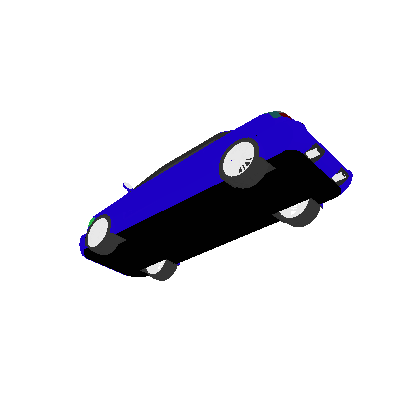
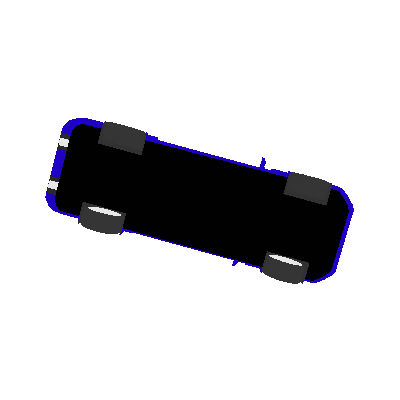
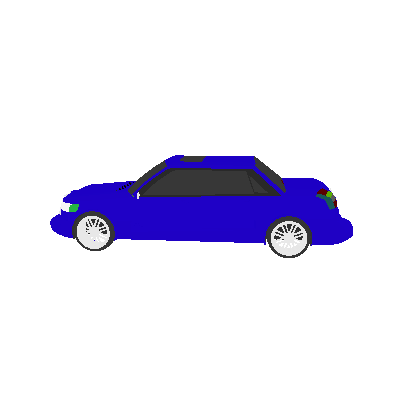
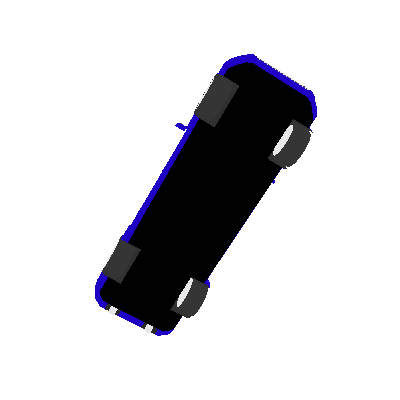
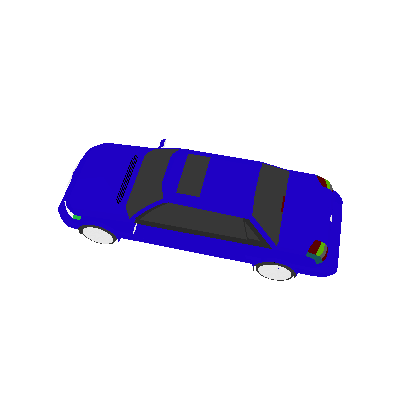
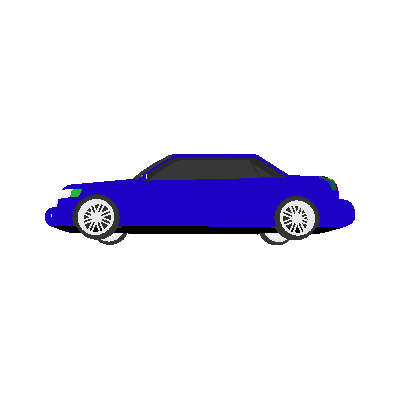
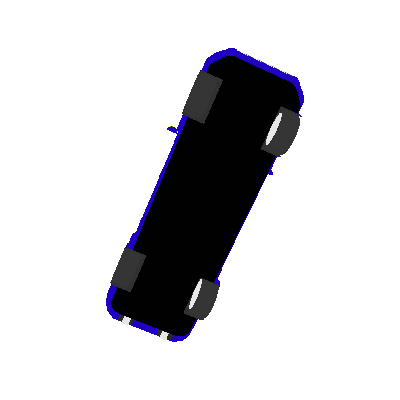
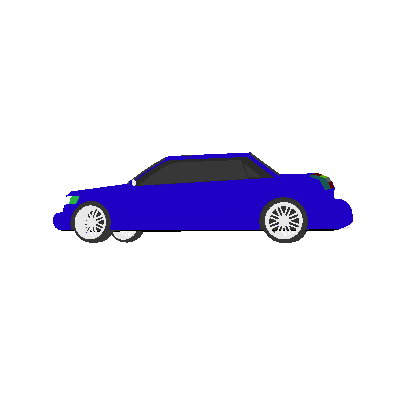


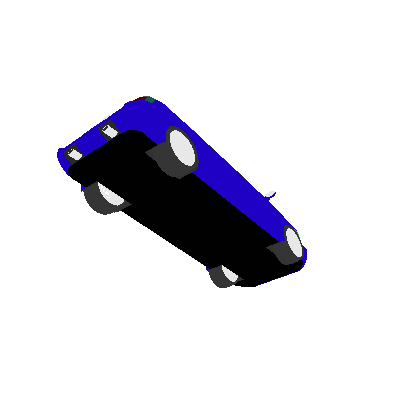
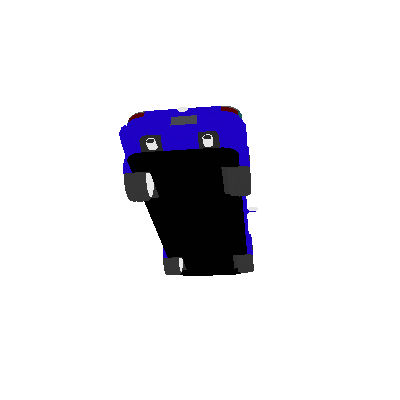
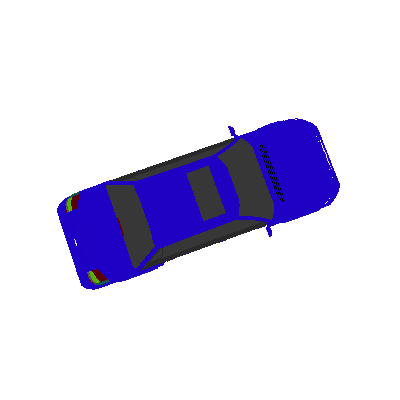
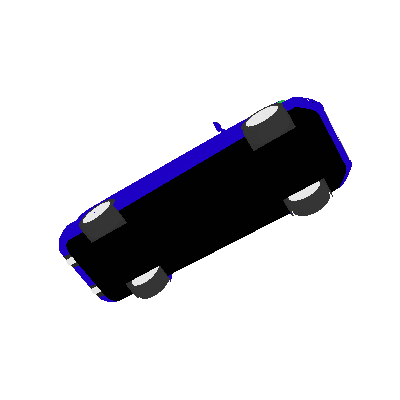
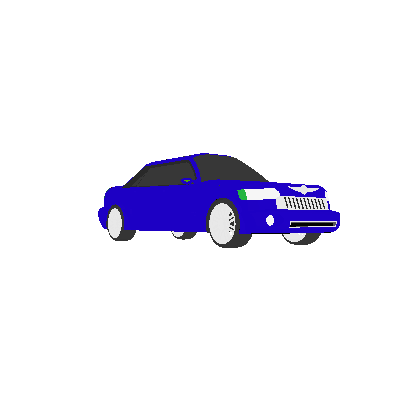
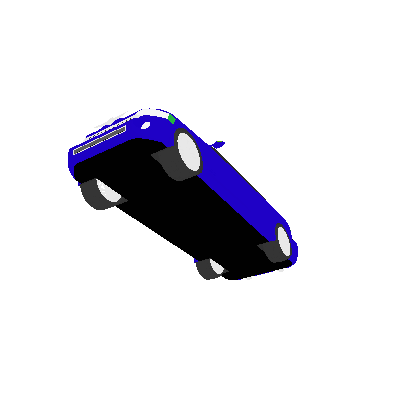
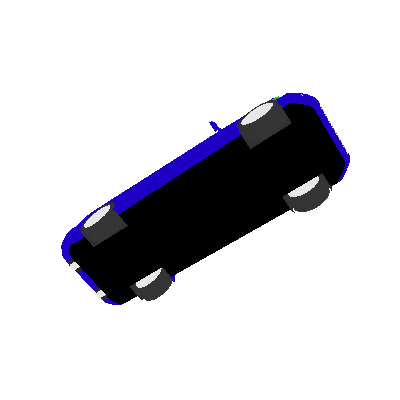
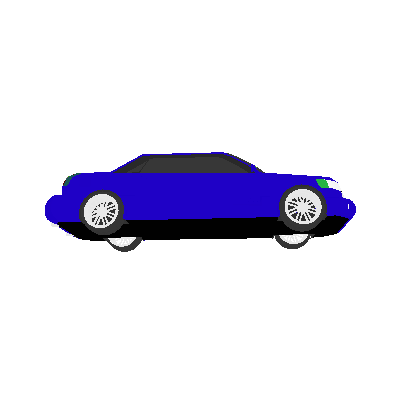
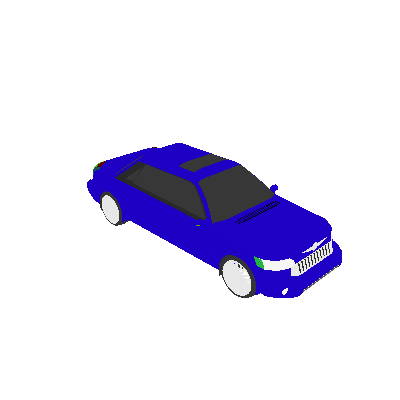
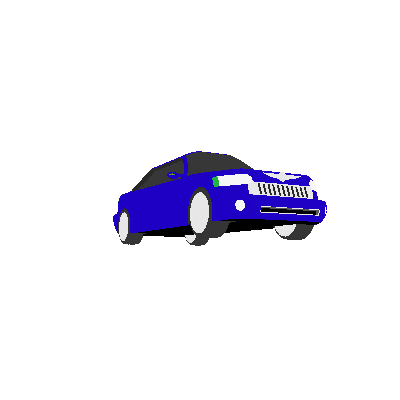
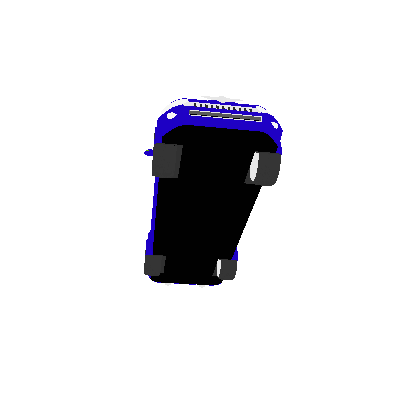
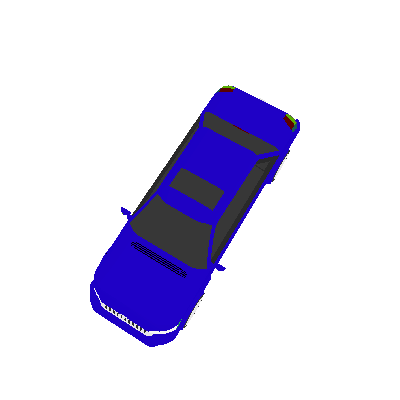
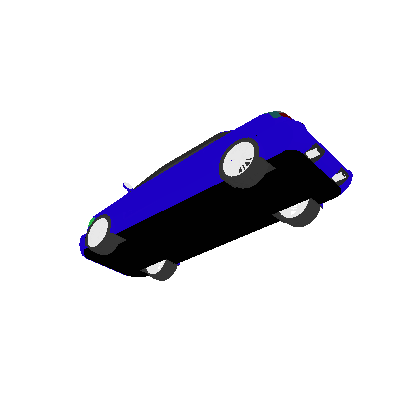
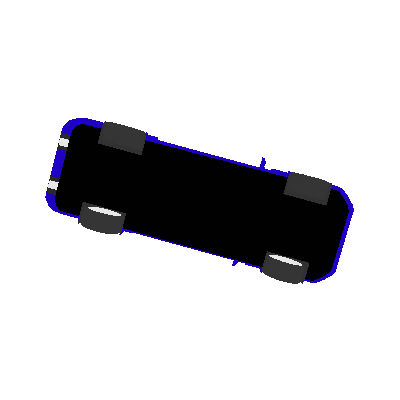
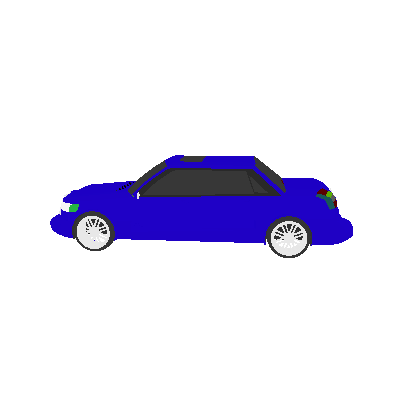
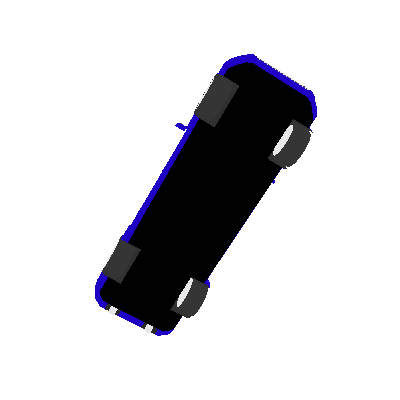
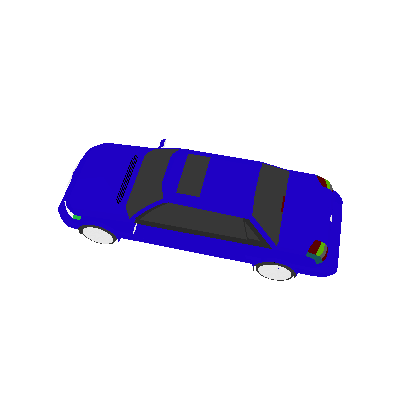
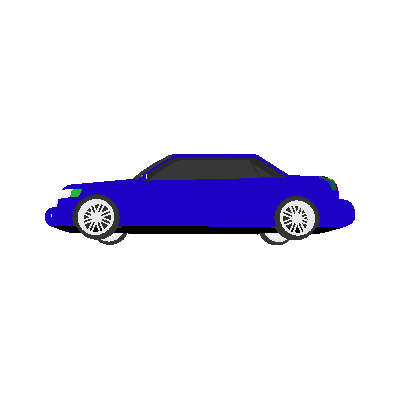
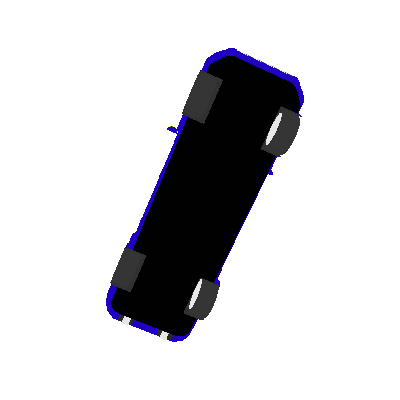
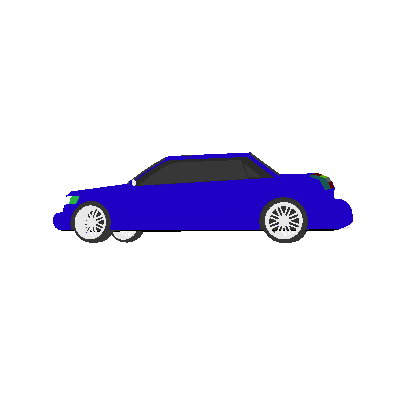

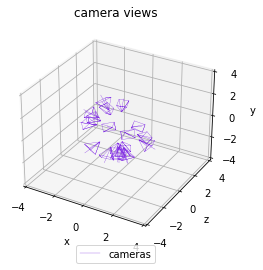


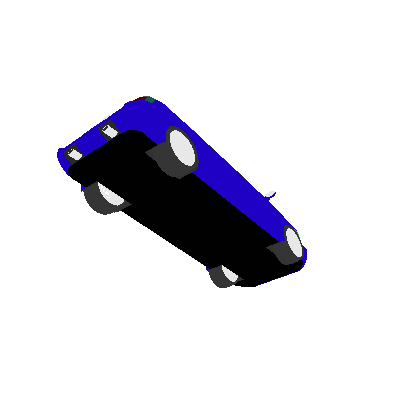
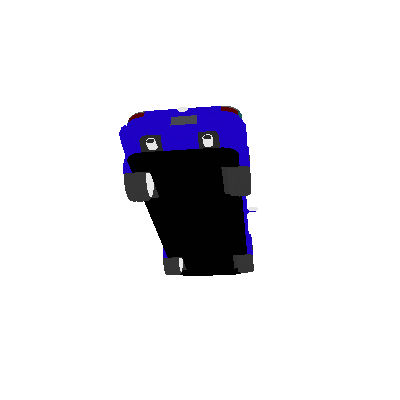
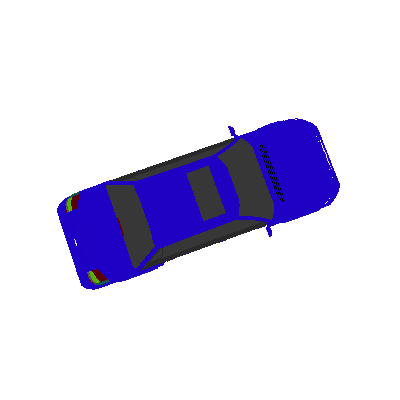
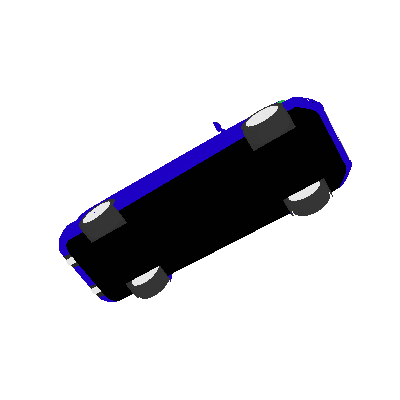
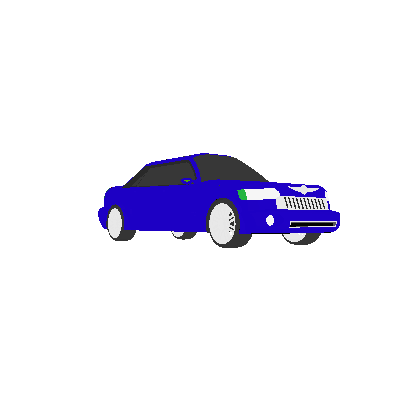
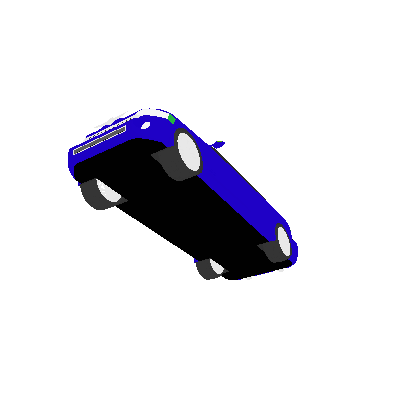
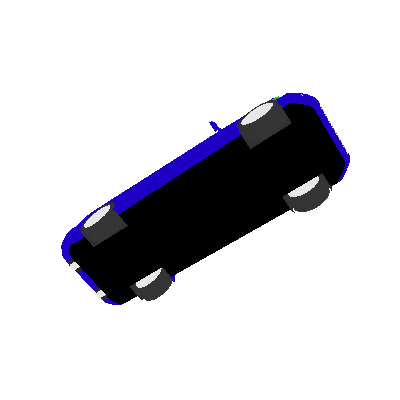
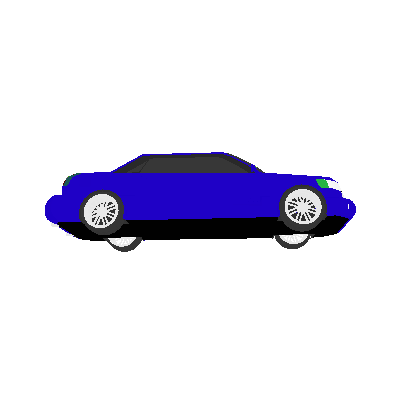
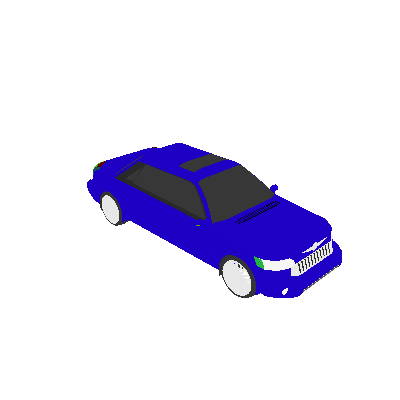
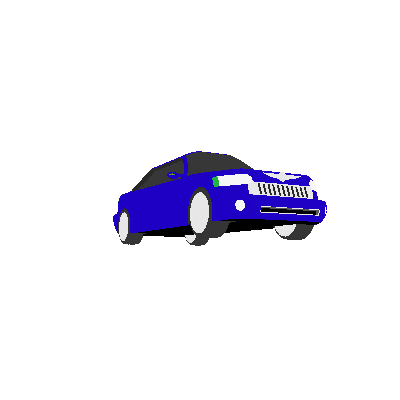
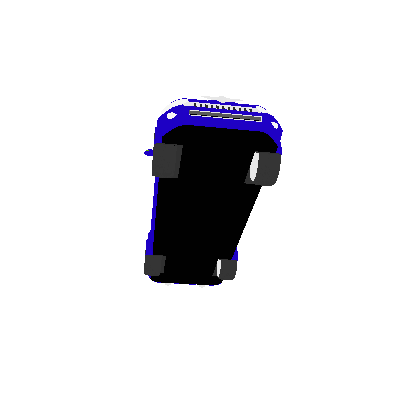
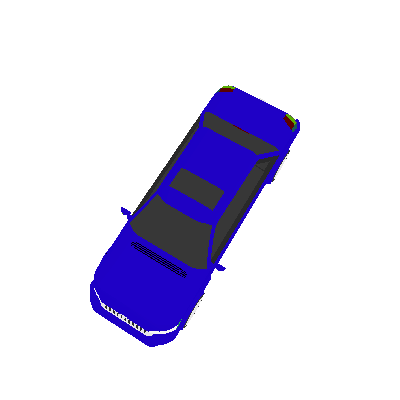
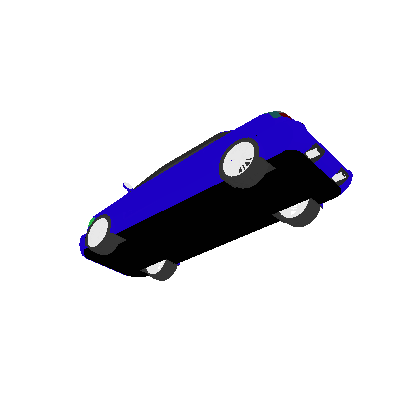
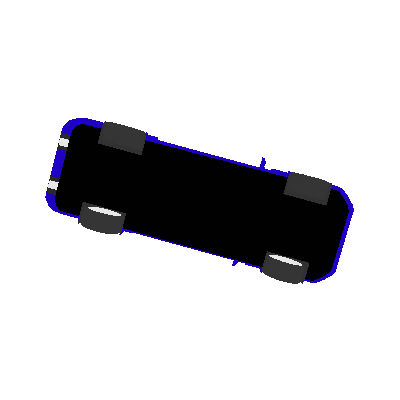
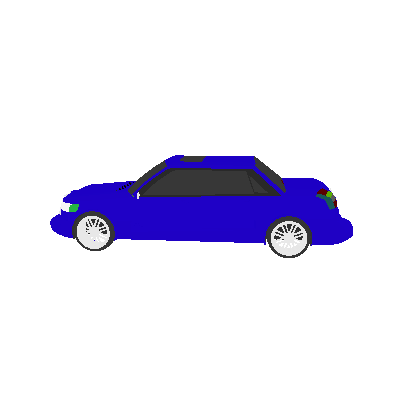
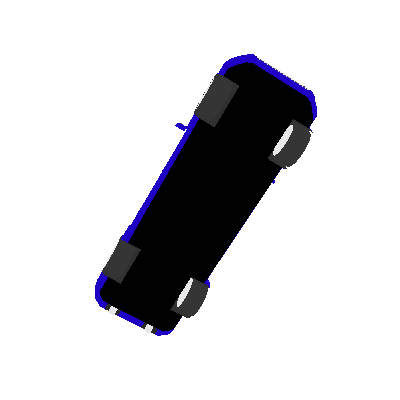
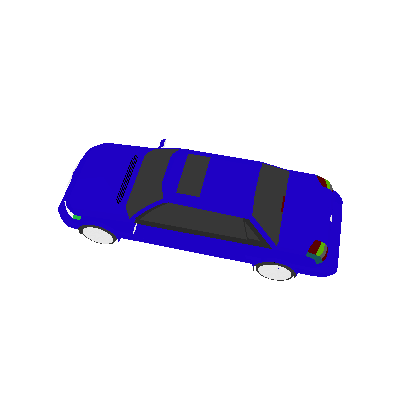
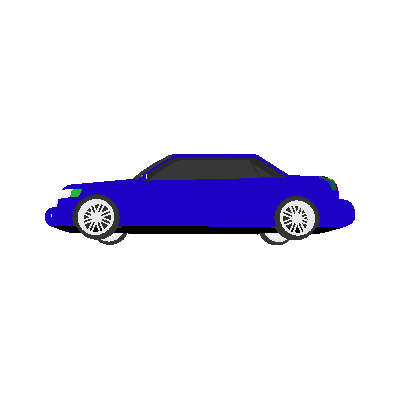
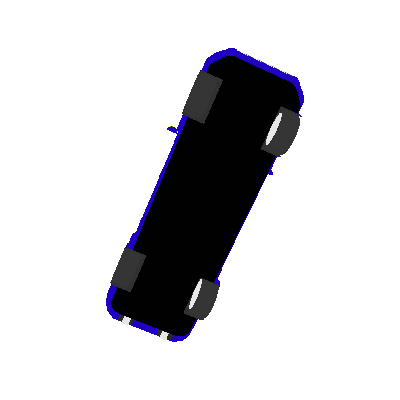
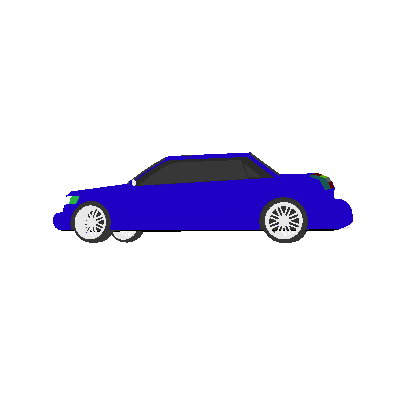


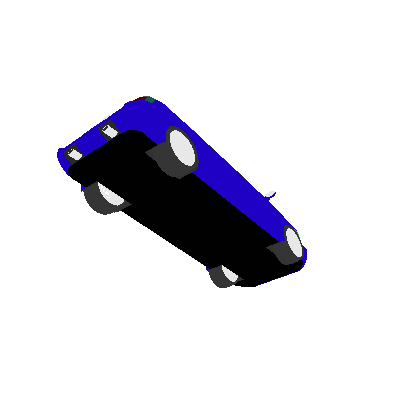
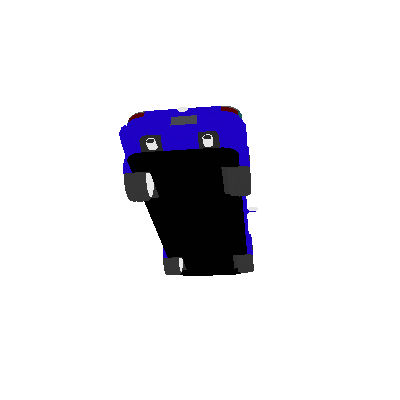
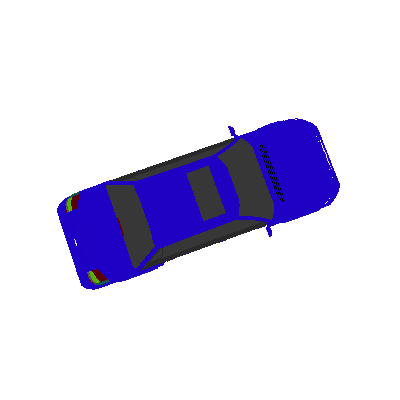
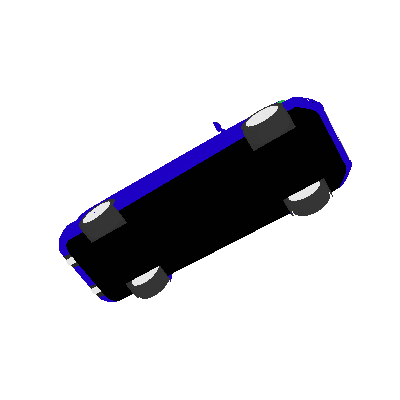
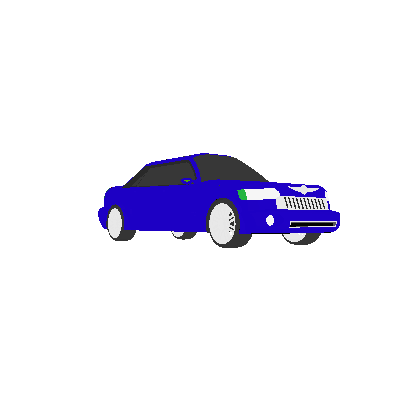
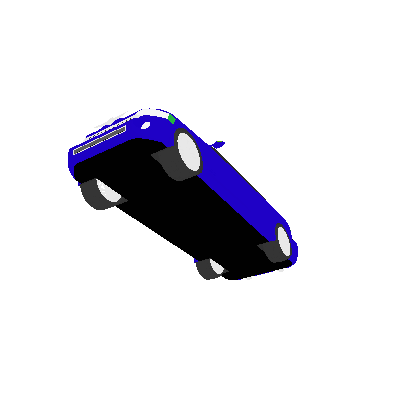
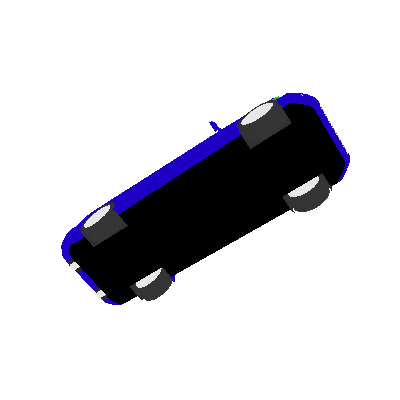
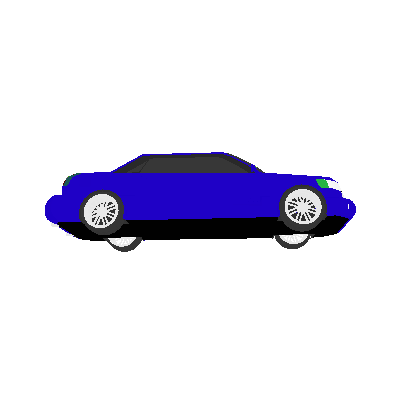
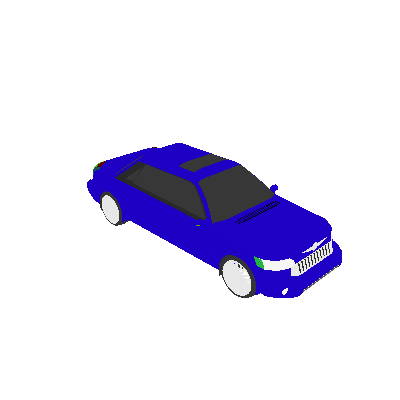
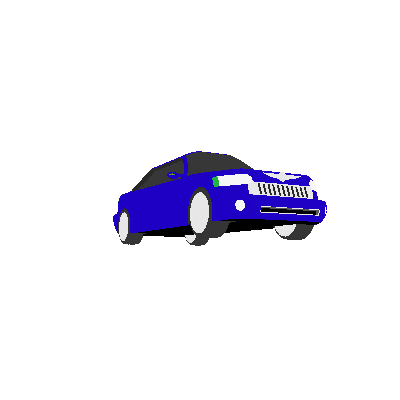
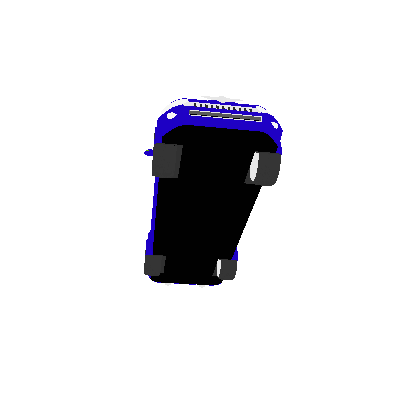
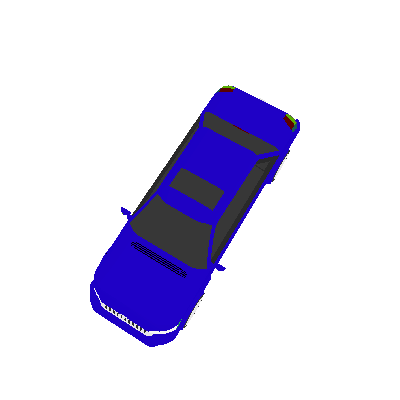
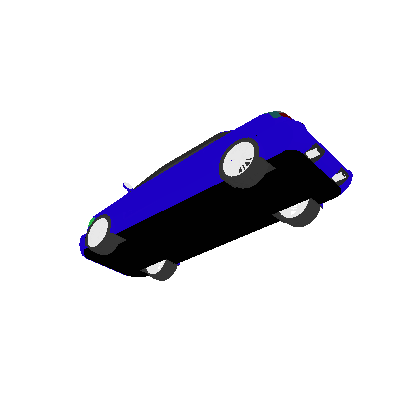
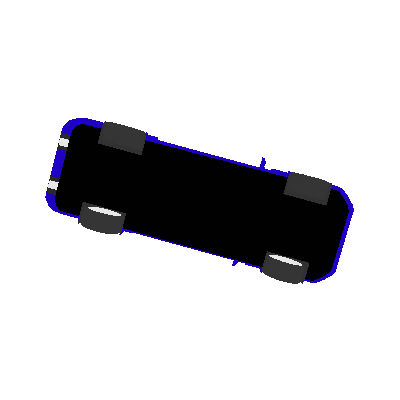
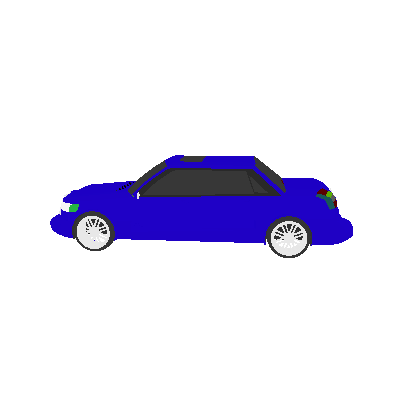
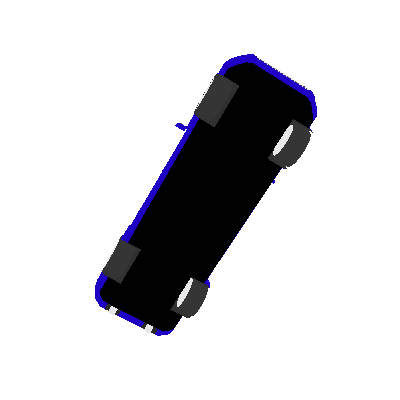
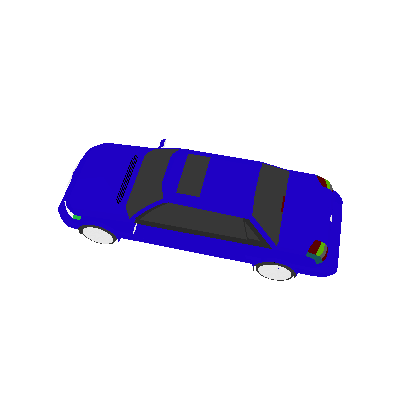
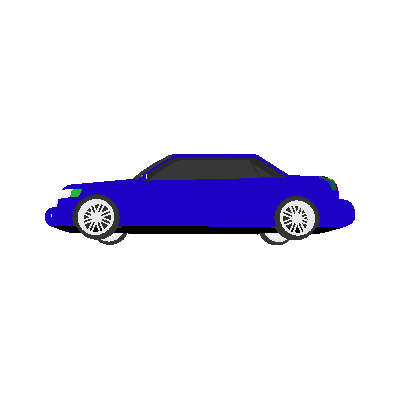
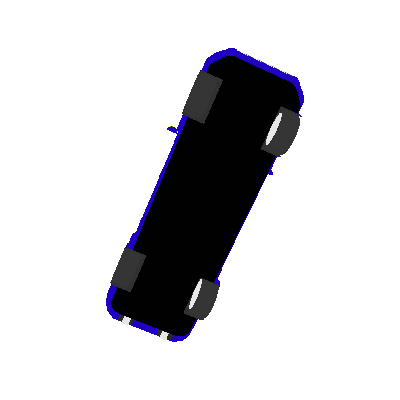
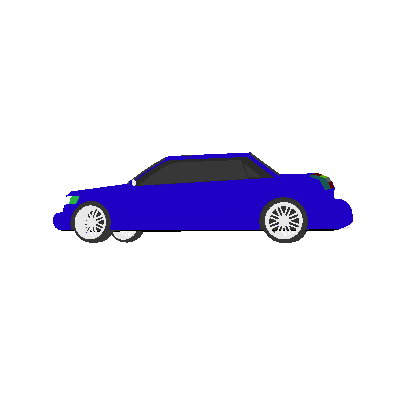

In [9]:
index = np.random.randint(0,len(dset)-1)
show_max_views = 40

c_data= dset[index]
print("shape path:{} \nimg_id:{} \nfocal length:{}".format(c_data["path"],c_data["img_id"],c_data["focal"]))
images_array = np.transpose(np.stack(c_data["images"],axis=0),(0,2,3,1))
ipyplot.plot_images(images_array, max_images=show_max_views, img_width=200)

images_array = np.transpose(np.stack(c_data["images"],axis=0),(0,2,3,1))
plot_camera_scene(c_data["poses"],status="camera views",scale=0.4)
ipyplot.plot_images(images_array, max_images=show_max_views, img_width=200)
